In [1]:
"""
Application of CFNO: Diffusion models for solving inverse problem
-Evaluations
@author: zhongjian wang
"""
from timeit import default_timer
from datetime import datetime
import numpy as np
import torch
import sys
sys.path.append('./codes/')

from my_fno_package import *
from my_fno_package_3d import *
import dm


In [2]:
## Wrapped plotting block
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plt_2d_compare(*mats):
    nmat = len(mats)
    fig, axes = plt.subplots(1, nmat,figsize=(nmat*5,6))
    fig.subplots_adjust(wspace=0.5)
    for ia in range(nmat):
        ax = axes[ia]
        im=ax.imshow(mats[ia])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad="5%")
        fig.colorbar(im,cax)
    plt.show()

In [3]:
class load_model:
    def __init__(self,PATH,schedule,dataset,operator_model,learning_model, \
    temb_continuous = False,colored_prior=False,print_on_screen=False):
        
        batch_size = 20
        self.batch_size =batch_size
        self.temb_model = 'MLP'
        grf = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.learning_model = learning_model
        t1 = default_timer()
        ## Data set
        ntrain = 10000 # It has to be the same as training, due to the encoder setting
        dset = dm.dataloader(dataset,ntrain,batch_size,batch_size)
        self.dset = dset
        self.theta_test1,self.y_test1 =dset.theta_test1.to(self.device),dset.y_test1.to(self.device)
        self.y_normalizer=dset.y_normalizer.to(self.device)
        self.theta_normalizer=dset.theta_normalizer.to(self.device)
        s = dset.s
        s1 =dset.s1
        self.s=s
        ################################################################
        # Model
        ################################################################
        self.vec_shape=(batch_size,1,)+(1,)*dset.dimension
        field_shape = (batch_size,1,)+ (s,)*dset.dimension
        field_pos = (1,)
        pos_d = 2
        for _ in range(dset.dimension):
            field_pos = field_pos +(pos_d,)
            pos_d = pos_d +1 
        # Schedule in backward sampling process
        t_list,lambda_list = dm.set_schedule(schedule)
        Nt = len(t_list)
        # Operators
        if operator_model == 'Unet':
            from unet import UNet
            self.model = UNet(image_channels=1,is_attn=(False, False, False, False),temb_model=self.temb_model,theta_channels=s1).to(self.device)
    
        else:
            # FNO settings
            if dset.dimension == 2:
                modes = 12
                width = 96 # in darcy case 96 is quite good
                self.model = FNO2d_emdT(modes, modes, width,temb_model=self.temb_model,theta_channels=s1).to(self.device)
            else:
                modes = 8
                width = 96 # in darcy case 96 is quite good
                self.model = FNO3d_emdT(modes, modes, modes, width,temb_model=self.temb_model,theta_channels=s1).to(self.device)
                FNO3d_emdT.padding =7

        self.model.load_state_dict(torch.load(PATH))
        self.model.eval()
        self.t_list_sample=np.insert(t_list,0,0)
        print( 'Model Initiated, No. parameters: ',str( sum(p.numel() for p in self.model.parameters() if p.requires_grad)))
        
    
    def sol(self,theta_test1,test_size=100):
        # compare with MCMC/reference solution
        t1 = default_timer()
        theta_test1=theta_test1.to(self.device)
        assert theta_test.shape[0]==self.batch_size
        solutions1 = []
        test_l21=0
        for _ in range(test_size//self.batch_size):
            z = dm.sample_z_from_model(self.model,theta_test1,self.s,self.t_list_sample,self.device,self.temb_model,self.learning_model,d = self.dset.dimension)
            z=self.y_normalizer.decode(z)
            solutions1.append(z)
        sols1=torch.cat(solutions1).squeeze().cpu().detach().numpy()
        total_time =default_timer()-t1
        print('Generation time:','%.3f'%total_time, 'Per Sample','%.3f'%(total_time/test_size) )
        return sols1

In [4]:
load_path = './results/R_cosine1_darcy-nscc_FNO_CEM_params_500epoch.npy'
schedule = 'cosine1'
learning_model = 'CEM'
operator_model = 'FNO'
dataset = 'darcy'

In [5]:
loaded = load_model(load_path,schedule,dataset,operator_model,learning_model,print_on_screen=True)
theta_test, y_test = loaded.dset.theta_test1,loaded.dset.y_test1

Model Initiated, No. parameters:  11452129


In [6]:
ysol = loaded.sol(theta_test,1000)


Generation time: 70.324 Per Sample 0.070


In [7]:
sols1_mean = np.mean(ysol,0)
sols1_std = np.std(ysol,0)
ref_mean = loaded.dset.mean2d_test1
ref_std = loaded.dset.std2d_test1
err_mean = np.sqrt(np.mean((sols1_mean-ref_mean)**2)/np.mean((ref_mean)**2))
err_std = np.sqrt(np.mean((sols1_std-ref_std)**2)/np.mean((ref_std)**2))

In [8]:
print(err_mean)
print(err_std)

0.0891272949610694
0.09170792443028922


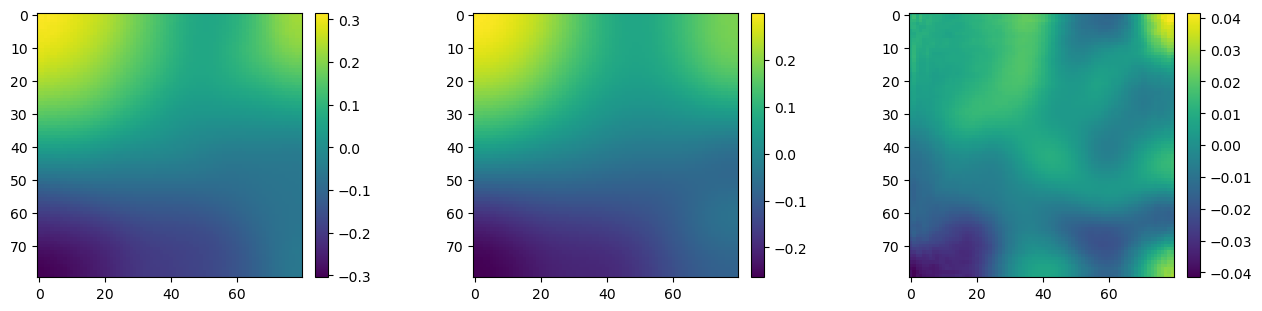

In [9]:
plt_2d_compare(sols1_mean[:,:],ref_mean[:,:],sols1_mean[:,:]-ref_mean[:,:])


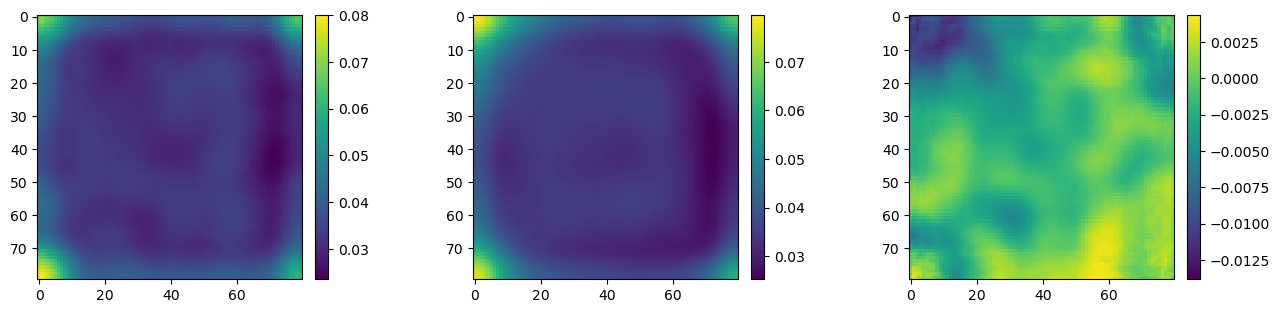

In [10]:
plt_2d_compare(sols1_std[:,:],ref_std[:,:],sols1_std[:,:]-ref_std[:,:])


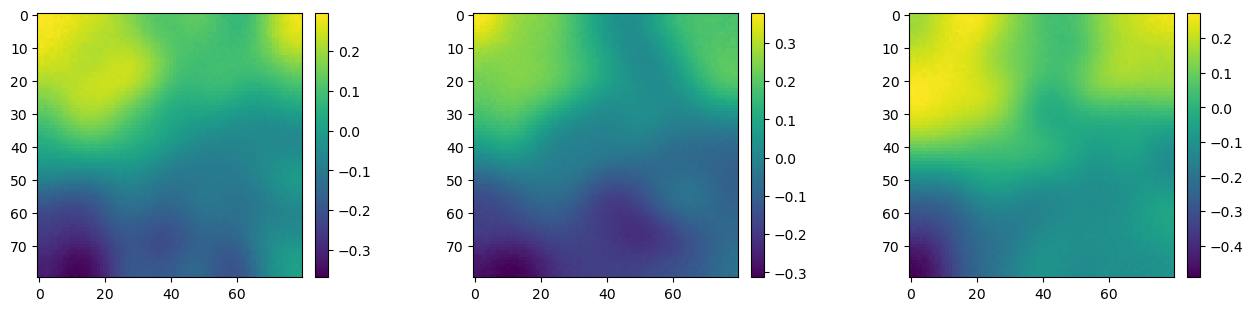

In [11]:
plt_2d_compare(ysol[0,:,:],ysol[10,:,:],ysol[20,:,:])


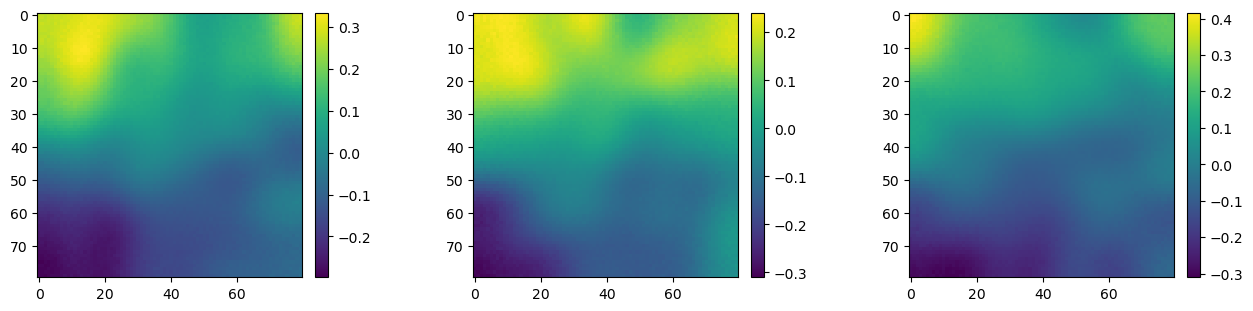

In [12]:
plt_2d_compare(ysol[30,:,:],ysol[40,:,:],ysol[50,:,:])